In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar

import enterprise_extensions
from enterprise_extensions.frequentist import optimal_statistic
from enterprise_extensions import models, model_utils, hypermodel

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from simFuncs import *
from enterprisePTAs import crnPTA, mcSample

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def HandD(x):
    c = (1-np.cos(x))/2
    return (1/2) - (1/4)*c+ (3/2)*c*np.log(c)

def plotBinnedCrossCor(xi,rho,sig,A_array,orfs=[HandD],bins=10,comp_names=['H&D']):
    temp = np.arange(0,len(xi),len(xi)/bins,dtype=np.int16)
    ranges = np.zeros(bins+1)
    ranges[0:bins]=temp
    ranges[bins]=len(xi)
    
    xiAvg = np.zeros(bins)
    rhoAvg = np.zeros(bins)
    sigmaComb = np.zeros(bins)
    
    #Need to sort by pulsar separation
    sortMask = np.argsort(xi)
    
    for i in range(bins):
        #Mask and select range of values to average
        subXi = xi[sortMask]
        subXi = subXi[int(ranges[i]):int(ranges[i+1])]
        subRho = rho[sortMask]
        subRho = subRho[int(ranges[i]):int(ranges[i+1])]
        subSig = sig[sortMask]
        subSig = subSig[int(ranges[i]):int(ranges[i+1])]
        
        #Useful to not type this out every time
        subSigSquare = np.square(subSig)
        
        #Average the separations, no weighting
        xiAvg[i] = np.average(subXi)
        
        #Average the correlated amplitude, with weighting
        rhoAvg[i] = np.sum(subRho/subSigSquare)/np.sum(1/subSigSquare)
        
        #Averaging the uncertanties
        sigmaComb[i] = 1/np.sqrt(np.sum(1/subSigSquare))
    
    #Plot data
    plt.errorbar(xiAvg,rhoAvg,yerr=sigmaComb,fmt='ro',label='Data')
    
    #Model plotting
    xvals = np.arange(0.05,np.pi,.05)
    totalY = np.zeros(len(xvals))
    #Plot individuals in dashed
    if type(A_array)!=list and type(A_array)!=np.ndarray:
        A_array = [A_array]
    for A, orf in zip(A_array,orfs):
        yvals = A*orf(xvals)
        totalY+=yvals
        plt.plot(xvals,yvals,'--')
        
    #Plot sum
    plt.plot(xvals,totalY,'b-')
    plt.legend(['Data']+comp_names+['summed orf'])
    plt.hlines(0,0,np.pi,'k')
    plt.title(f'Binned correlation data with {len(orfs)} components')
    plt.xlabel('Pulsar separation')
    plt.ylabel('Correlated applitude')
    plt.show()


In [49]:
parfiles = sorted(glob.glob('mdc2/*.par'))
obstimes = 53000.0 + np.linspace(0.0,20.0,520) * 365.25

ltpsrs = create_psrs(parfiles,obstimes,toaerr=0.01)
add_gwb(ltpsrs,amp=1e-14)
psrs = lt2ent(ltpsrs)

[preProcess.C:158] Warning: PSR J0030+0451 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0034-0534 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0218+4232 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0437-4715 uses DM2+ but does not define DM_SERIES. Assume Taylor. This has behaviour has changed since June 2020!
See https://bitbucket.org/psrsoft/tempo2/issues/27/tempo2-dm-polynomial-is-not-a-taylor

[preProcess.C:158] Warning: PSR J0613-0200 uses DM2+ but

In [50]:
pta = crnPTA(psrs,fixedGamma=True)

In [55]:
OS = optimal_statistic.OptimalStatistic(psrs,bayesephem=False,gamma_common=4.33,
                                        orf='monopole',pta=pta)


In [56]:
xi,rho,sig,os,os_sig = OS.compute_os(params={'gw_log10_A':-14})
print(os,os_sig)

1.0993843231006684e-30 9.811038813657097e-31


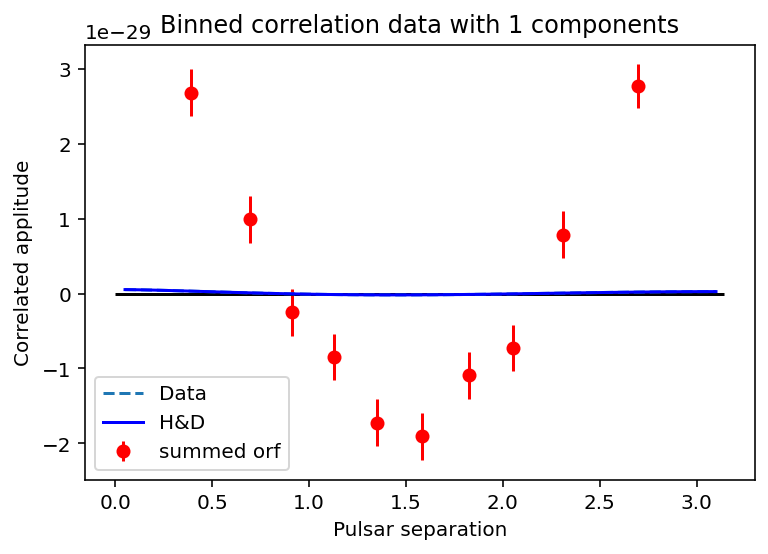

In [57]:
plotBinnedCrossCor(xi,rho,sig,[os])